In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def dydx(x , y):
    
    y_derivs = np.zeros(2)
    
    y_derivs[0] = y[1]
    y_derivs[1] = -1 * y[0]

    return y_derivs

In [9]:
def cash_karp_core(dydx, xi, yi, nv, h):
    
    c = [0 , 0 , 1/5 , 3/10 , 3/5 , 1 , 7/8]
    
    a2 = [0 , 1/5]
    a3 = [0 , 3/40 , 9/40]
    a4 = [0 , 3/10 , -9/10 , 6/5]
    a5 = [0 , -11/54 , 5/2 , -70/27 , 35/27]
    a6 = [0 , 1631/55296 , 175/512 , 575/13824 , 44275/110592 , 253/4096]
    
    k_1 = h * dydx(xi          , yi)
    k_2 = h * dydx(xi + c[2]*h , yi + a2[1]*k_1)
    k_3 = h * dydx(xi + c[3]*h , yi + a3[1]*k_1 + a3[2]*k_2)
    k_4 = h * dydx(xi + c[4]*h , yi + a4[1]*k_1 + a4[2]*k_2 + a4[3]*k_3)
    k_5 = h * dydx(xi + c[5]*h , yi + a5[1]*k_1 + a5[2]*k_2 + a5[3]*k_3 + a5[4]*k_4)
    k_6 = h * dydx(xi + c[6]*h , yi + a6[1]*k_1 + a6[2]*k_2 + a6[3]*k_3 + a6[4]*k_4 + a6[5]*k_5)
    
    b = [0 , 37/378 , 0 , 250/621 , 125/594 , 0 , 512/1771]
    bs = [0, 2825/27648 , 0 , 18575/48384 , 13525/55296 , 277/14336 , 1/4]
    
    y_ipo = yi + b[1]*k_1 + b[2]*k_2 + b[3]*k_3 + b[4]*k_4 + b[5]*k_5 + b[6]*k_6
    ys_ipo = yi + bs[1]*k_1 + bs[2]*k_2 + bs[3]*k_3 + bs[4]*k_4 + bs[5]*k_5 + bs[6]*k_6
    
    dx = y_ipo - ys_ipo
    
    y_ipo = dx + ys_ipo
    
    return y_ipo

In [10]:
def cash_karp_ad(dydx, x_i, y_i, nv, h, tol):
    
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    imax = 10000
    i = 0
    
    Delta = np.full(nv , 2*tol)
    
    h_step = h
    
    while(Delta.max()/tol > 1.0):
        
        y_2 = cash_karp_core(dydx , x_i , y_i , nv , h_step)
        y_1 = cash_karp_core(dydx , x_i , y_i , nv , 0.5*h_step)
        y_11 = cash_karp_core(dydx , x_i + 0.5*h_step , y_1 , nv , 0.5*h_step)
        
        Delta = np.fabs(y_2 - y_11)
        
        if(Delta.max()/tol > 1.0):
            
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        if(i>=imax):
            print("Too many iterations in cash_karp_ad().")
            raise StopIteration("Ending after i = " , i)
            
        i += 1
        
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9) , h_step * H_NEW_FAC)
    
    return y_2 , h_new, h_step

In [11]:
def cash_karp(dydx , a , b , y_a , tol):
    
    xi = a
    
    yi = y_a.copy()
    
    h = 1.0e-4 * (b-a)
    
    imax = 10000
    i = 0
    
    nv = len(y_a)
    
    x = np.full(1 , a)
    
    y = np.full( (1, nv) , y_a)
    
    flag = 1
    
    while(flag):
        
        yi_new , h_new , h_step = cash_karp_ad(dydx, xi, yi, nv, h, tol)
        
        h = h_new
        
        if(xi + h_step > b):
            
            h = b - xi
            
            yi_new, h_new, h_step = cash_karp_ad(dydx, xi, yi, nv, h, tol)
            
            flag = 0
            
        xi += h_step
        
        yi = yi_new
        
        x = np.append(x, xi)
        
        y_new = np.zeros( (len(x), nv) )
        
        y_new[0:len(x) - 1 , :] = y
        
        y_new[-1 , :] = yi[:]
        
        del y
        
        y = y_new
        
        if(i>=imax):
            print("Too many iterations in rk4_mv().")
            raise StopIteration("Ending after i = ", i)
            
        i += 1
        
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb = %9.8f" % (i, xi, h_step, b)
        print(s)
        
        if(xi==b):
            flag = 0
            
    return x,y

In [12]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0

nv = 2

tolerance = 1.0e-6

x, y = cash_karp(dydx , a , b , y_0 , tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b = 6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b = 6.28318531
i =  11	x = 0.95166461	h = 0.30889476	b = 6.28318531
i =  12	x = 1.26805818	h = 0.31639356	b = 6.28318531
i =  13	x = 1.58812907	h = 0.32007089	b = 6.28318531
i =  14	x = 1.92439441	h = 0.33626534	b = 6.28318531
i =  15	x = 2.23091949	h = 0.30652508	b = 6.28318531
i =  16	x = 2.54903350	h = 0.31811400	b = 6.28318531
i =  17	x = 2.86042607	h = 0.31139258	b = 6.28318531
i =  18	x = 3.18409468	h = 0.32366861	b = 6.28318531
i =  19	x = 3.51559780	h = 0.33150312	b = 6.28

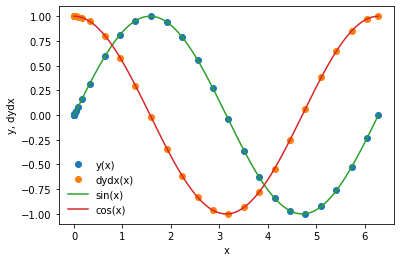

In [13]:
plt.plot(x, y[:,0], 'o', label='y(x)')
plt.plot(x, y[:,1], 'o', label='dydx(x)')

xx = np.linspace(0, 2.0 * np.pi, 1000)

plt.plot(xx, np.sin(xx), label='sin(x)')
plt.plot(xx, np.cos(xx), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dydx')
plt.legend(frameon=False)

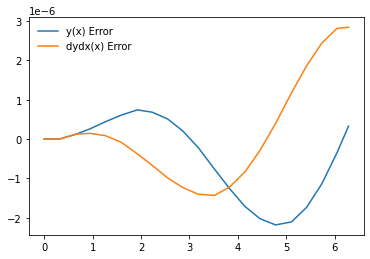

In [14]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0] - sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x, y_error, label='y(x) Error')
plt.plot(x, dydx_error, label='dydx(x) Error')
plt.legend(frameon = False)